In [1]:
import pandas as pd
import numpy as np
import pywt
import tushare as ts
from sklearn import preprocessing
from sklearn import metrics

In [2]:
# 获取tushare数据
cons=ts.get_apis()
def get_data(start_date='2005-01-01',end_date=''):
    all_data = ts.bar('000300', conn=cons, asset='INDEX', start_date=start_date, end_date=end_date)
    all_data=all_data.dropna()
    all_data=all_data[::-1]
    return all_data

train_dataframe = get_data(start_date='2005-01-01',end_date='2014-12-31')
test_dataframe = get_data(start_date='2015-01-01',end_date='')
test_dataframe.head()

,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2015-01-06,000300,3608.43,3641.06,3683.23,3587.23,4209621.0,4.985296e+11,-0.01
2015-01-07,000300,3620.92,3643.79,3671.19,3601.70,3201912.0,3.987317e+11,0.07
2015-01-08,000300,3650.07,3559.26,3659.94,3552.10,2950030.0,3.558320e+11,-2.32
2015-01-09,000300,3547.57,3546.72,3689.75,3536.40,3499826.0,4.302106e+11,-0.35
2015-01-12,000300,3531.51,3513.58,3560.53,3461.32,2665671.0,3.342571e+11,-0.93


In [3]:
print(train_dataframe.columns.tolist()[1:7])
name_dict = {name:index for index,name in enumerate(train_dataframe.columns.tolist()[1:7])}
name_dict_inv = {index:name for index,name in enumerate(train_dataframe.columns.tolist()[1:7])}
print(name_dict)
print(name_dict_inv)

['open', 'close', 'high', 'low', 'vol', 'amount']
{'open': 0, 'close': 1, 'high': 2, 'low': 3, 'vol': 4, 'amount': 5}
{0: 'open', 1: 'close', 2: 'high', 3: 'low', 4: 'vol', 5: 'amount'}


In [4]:
def wavelet_reconstruct(data,wavelet,threshold):
    # 选用小波
    w = pywt.Wavelet(wavelet) 
    maxlev = pywt.dwt_max_level(len(data),w.dec_len)
    coeffs = pywt.wavedec(data,wavelet,level=maxlev)

    # 将噪声滤波
    for i in range(1,len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i],threshold*max(coeffs[i]))
    
    # 重建数据
    data_rec = pywt.waverec(coeffs,wavelet)
    
    return data_rec

def compare_plot(data_source,data_rec):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot([i for i in range(len(data_source))],data_source)
    plt.title('Raw Signal')
    
    plt.subplot(2, 1, 2)
    plt.plot([i for i in range(len(data_rec))],data_rec)
    plt.title('De-noised signal')
    
    plt.tight_layout()
    plt.show()
         
# Example  
# open_value = data['open'].astype('float32')
# open_value_rec = wavelet_reconstruct(open_value,'db8',0.1)
# compare_plot(open_value,open_value_rec)

In [5]:
def construct_data(dataframe,wavelet,threshold,is_wavelet=False):
    if is_wavelet:
        all_data = []
        for name in name_dict.keys():
            data = dataframe[name].astype('float32')
            data_rec = wavelet_reconstruct(data,wavelet,threshold)
            all_data.append(data_rec)
        all_data = np.array(all_data).T
    else:
        all_data = [dataframe[name].astype('float32') for name in name_dict.keys()]
        all_data = np.array(all_data).T
    return all_data

train_data = construct_data(train_dataframe,wavelet='db8',threshold=0.2,is_wavelet=True)
test_data = construct_data(test_dataframe,wavelet='db8',threshold=0.2,is_wavelet=True)
print(train_data.shape)
print(test_data.shape)

(2426, 6)
(1302, 6)


In [6]:
# 这里两者用同一个scaler，确保test时的信息全部来自于train
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
train_scaled_data = scaler.fit_transform(train_data)
test_scaled_data = scaler.fit_transform(test_data)

In [7]:
# 切割的独立矩阵块大小，通常以windows-1日作为训练矩阵块，最后一日为真实矩阵块，用于验证预测答案
def divide_data(data,window_size):
    # 类似于卷积，这里设置步长为1
    n_items = data.shape[0] - window_size + 1
    # 最后分割好的独立矩阵块
    final_items = np.zeros([n_items,window_size,data.shape[1]])
    for index_item in range(n_items):
        matrix = data[index_item:index_item + window_size,:].copy()
        final_items[index_item,:,:] = matrix
    return final_items

window_size = 11
train_group_scaled_data = divide_data(train_scaled_data,window_size)
test_group_scaled_data = divide_data(test_scaled_data,window_size)

print(train_group_scaled_data.shape)
print(test_group_scaled_data.shape)

(2416, 11, 6)
(1292, 11, 6)


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Data
x_train = train_group_scaled_data[:,:-1,:] # (train_length,10,6),data
y_train = train_group_scaled_data[:,-1,:]  # (train_length,1,6) = (train_length,6),label
x_test = test_group_scaled_data[:,:-1,:]   # (test_length,10,6),data
y_test = test_group_scaled_data[:,-1,:]    # (test_length,1,6) = (test_length,6),label

# Train
model = Sequential()
model.add(LSTM(64,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(LSTM(32,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=False))
model.add(Dense(16,kernel_initializer='uniform',activation='relu'))
model.add(Dense(x_train.shape[2],kernel_initializer='uniform',activation='linear'))
model.compile(loss=rmse,optimizer='adam')
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
model.fit(x_train,y_train,epochs=500,batch_size=128,validation_split=0.1,verbose=1,shuffle=True,callbacks=[early_stopping])

# Prediction
y_pred = model.predict(x_test)
for name,index in name_dict.items():
    print(name + " R Square =",metrics.r2_score(y_test[:,index],y_pred[:,index]))
    print(name + " RMSE =",metrics.mean_squared_error(y_test[:,index],y_pred[:,index])** 0.5)
    print(name + " MAE =",metrics.mean_absolute_error(y_test[:,index],y_pred[:,index]))
    print()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            18176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 31,222
Trainable params: 31,222
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 2174 samples, validate on 242 samples
Epoch 1/500
2174/2174 [==============================] - 3s 1ms/step - loss: 0.2867 - val_loss: 0.2526


2174/2174 [==============================] - 0s 199us/step - loss: 0.0089 - val_loss: 0.0338
Epoch 65/500
2174/2174 [==============================] - 0s 198us/step - loss: 0.0081 - val_loss: 0.0346
Epoch 66/500
2174/2174 [==============================] - 0s 201us/step - loss: 0.0076 - val_loss: 0.0336
Epoch 67/500
2174/2174 [==============================] - 0s 199us/step - loss: 0.0079 - val_loss: 0.0338
Epoch 68/500
2174/2174 [==============================] - 0s 199us/step - loss: 0.0077 - val_loss: 0.0341
Epoch 69/500
2174/2174 [==============================] - 0s 195us/step - loss: 0.0073 - val_loss: 0.0333
Epoch 70/500
2174/2174 [==============================] - 0s 203us/step - loss: 0.0075 - val_loss: 0.0331
Epoch 71/500
2174/2174 [==============================] - 0s 198us/step - loss: 0.0077 - val_loss: 0.0336
Epoch 72/500
2174/2174 [==============================] - 0s 196us/step - loss: 0.0076 - val_loss: 0.0334
Epoch 73/500
2174/2174 [==============================] - 0

2174/2174 [==============================] - 0s 194us/step - loss: 0.0058 - val_loss: 0.0251
Epoch 142/500
2174/2174 [==============================] - 0s 197us/step - loss: 0.0060 - val_loss: 0.0252
Epoch 143/500
2174/2174 [==============================] - 0s 194us/step - loss: 0.0065 - val_loss: 0.0246
Epoch 144/500
2174/2174 [==============================] - 0s 196us/step - loss: 0.0059 - val_loss: 0.0252
Epoch 145/500
2174/2174 [==============================] - 0s 207us/step - loss: 0.0059 - val_loss: 0.0248
Epoch 146/500
2174/2174 [==============================] - 0s 210us/step - loss: 0.0057 - val_loss: 0.0242
Epoch 147/500
2174/2174 [==============================] - 0s 214us/step - loss: 0.0062 - val_loss: 0.0250
Epoch 148/500
2174/2174 [==============================] - 0s 208us/step - loss: 0.0064 - val_loss: 0.0244
Epoch 149/500
2174/2174 [==============================] - 0s 195us/step - loss: 0.0063 - val_loss: 0.0247
Epoch 150/500
2174/2174 [==========================

2174/2174 [==============================] - 0s 205us/step - loss: 0.0050 - val_loss: 0.0189
Epoch 218/500
2174/2174 [==============================] - 0s 211us/step - loss: 0.0050 - val_loss: 0.0191
Epoch 219/500
2174/2174 [==============================] - 0s 206us/step - loss: 0.0053 - val_loss: 0.0202
Epoch 220/500
2174/2174 [==============================] - 0s 202us/step - loss: 0.0056 - val_loss: 0.0192
Epoch 221/500
2174/2174 [==============================] - 0s 194us/step - loss: 0.0050 - val_loss: 0.0187
Epoch 222/500
2174/2174 [==============================] - 0s 198us/step - loss: 0.0048 - val_loss: 0.0187
Epoch 223/500
2174/2174 [==============================] - 0s 197us/step - loss: 0.0051 - val_loss: 0.0193
Epoch 224/500
2174/2174 [==============================] - 0s 207us/step - loss: 0.0054 - val_loss: 0.0189
Epoch 225/500
2174/2174 [==============================] - 0s 199us/step - loss: 0.0054 - val_loss: 0.0197
Epoch 226/500
2174/2174 [==========================

{'open': 0, 'close': 1, 'high': 2, 'low': 3, 'vol': 4, 'amount': 5}
{0: 'open', 1: 'close', 2: 'high', 3: 'low', 4: 'vol', 5: 'amount'}


[None]

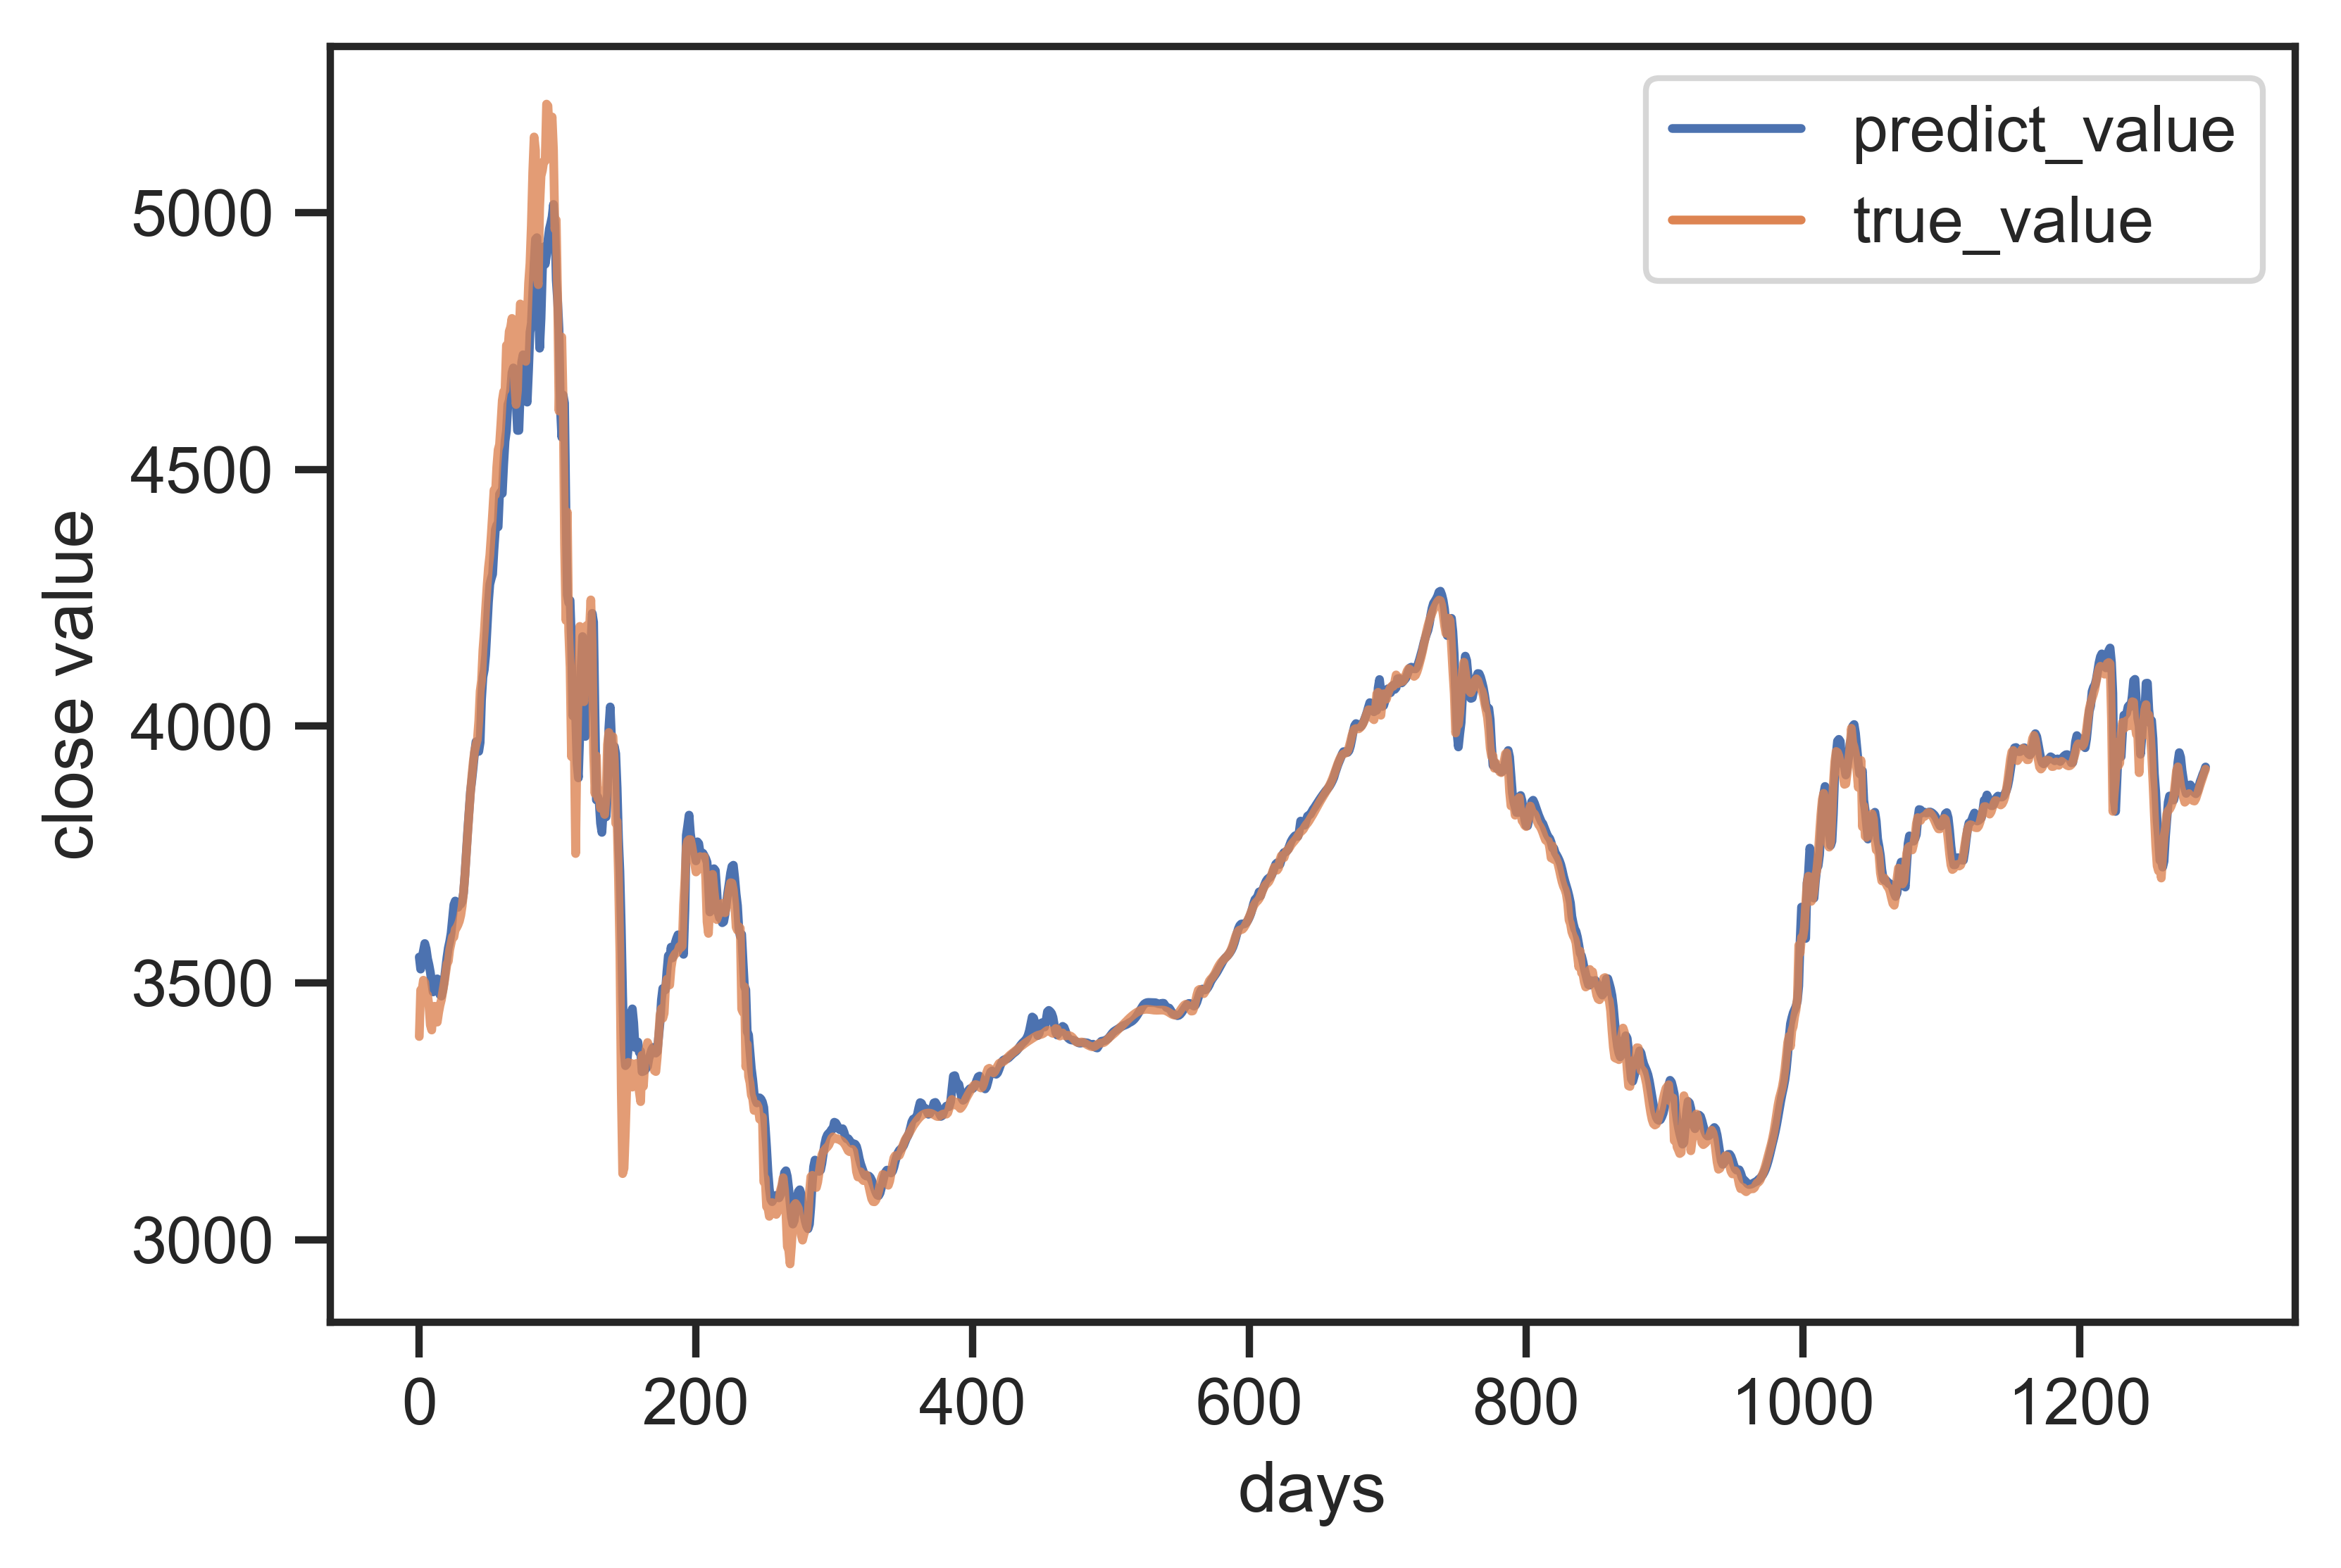

In [11]:
# 归一化反变换，用于画图
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)
x_item = [i for i in range(len(y_pred_unscaled))]
print(name_dict)
print(name_dict_inv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
plt.figure(dpi=600)

# 选一项进行画图
select_number = name_dict['close']

# 画图
draw_dataframe = pd.DataFrame({'predict_value':y_pred_unscaled[:,select_number],'true_value':y_test_unscaled[:,select_number]})
p = sns.lineplot(data=draw_dataframe,dashes = False)

# 设置图表标题
p.set_xlabel('days')
p.set_ylabel(name_dict_inv[select_number] + ' value')

# 给橙色线设置透明度，用于辨识重合的部分
plt.setp([p.get_children()[1]],alpha=0.8)